# Plot correspondences in registration

## Imports and magics

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import ipywidgets as ipyw
import matplotlib.animation as animation
from mpl_toolkits.axes_grid1 import make_axes_locatable
from IPython.display import HTML

from otimage import imagerep, io
from otimage.utils import plot_maxproj
from otimage.imagereg import ot_registration, gw_registration

## Load Zimmer data

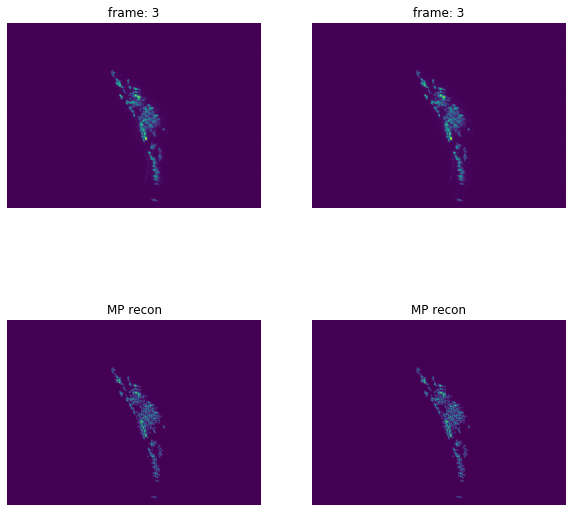

In [3]:
# Frame index
t1 = 3
t2 = 3

# Load two successive frames from dataset
img_path = '/home/mn2822/Desktop/WormOT/data/zimmer/raw/mCherry_v00065-00115.hdf5'
with io.ZimmerReader(img_path) as reader:
    img_1 = reader.get_frame(t1)
    img_2 = reader.get_frame(t2)
    img_shape = img_1.shape

# Load MP components
mp_path = '/home/mn2822/Desktop/WormOT/data/zimmer/mp_components/mp_0000_0050.mat'
with io.MPReader(mp_path) as reader:
    mp_1 = reader.get_frame(t1)
    mp_2 = reader.get_frame(t2)

# Reconstruct images from MPs
rec_1 = imagerep.reconstruct_mp_image(mp_1)
rec_2 = imagerep.reconstruct_mp_image(mp_2)
  
plt.figure(figsize=(10, 10))

plt.subplot(221)
plot_maxproj(img_1)
plt.title(f'frame: {t1}')
plt.axis('off')

plt.subplot(222)
plot_maxproj(img_2)
plt.title(f'frame: {t2}')
plt.axis('off');

plt.subplot(223)
plot_maxproj(rec_1)
plt.title('MP recon')
plt.axis('off')

plt.subplot(224)
plot_maxproj(rec_2)
plt.title('MP recon')
plt.axis('off');

## Compute registration for images

In [4]:
degree = 2
n_iter = 50

model, debug = gw_registration(mp_1, mp_2, degree=degree, n_iter=n_iter)

print('beta (est):')
print(model.beta)

beta (est):
[[-4.14571182e-10  1.00000000e+00  5.69458749e-13 -3.86613758e-14
  -9.42459005e-16 -9.10993262e-16 -3.62171358e-17 -1.54959158e-16
   3.90620077e-17 -1.15307463e-16]
 [-9.40620380e-11  2.68380446e-13  1.00000000e+00  7.35738263e-15
  -1.51467428e-16 -1.62169217e-17  8.64100280e-17  1.76117687e-16
  -6.41340266e-17  2.28040272e-16]
 [ 2.42575918e-10 -8.86552216e-13 -1.73333691e-13  1.00000000e+00
   7.95876301e-16  3.63157363e-16  1.40967547e-17 -1.14670097e-17
   7.12764061e-17  1.50065562e-16]]


## Compute pushforward with identified MP component

In [5]:
# Transform MP points for first image using mapping
pf_pts = model.predict(mp_1.pts).astype(int)

## Plot color-coded correspondence

In [6]:
def get_mp_colors(pts):
     
    colors_sorted = cm.rainbow(np.linspace(0, 1, pts.shape[0]))
    sort_idx = np.lexsort((pts[:, 0], pts[:, 1]))
    unsort_idx = np.argsort(sort_idx)
    
    return colors_sorted[unsort_idx]

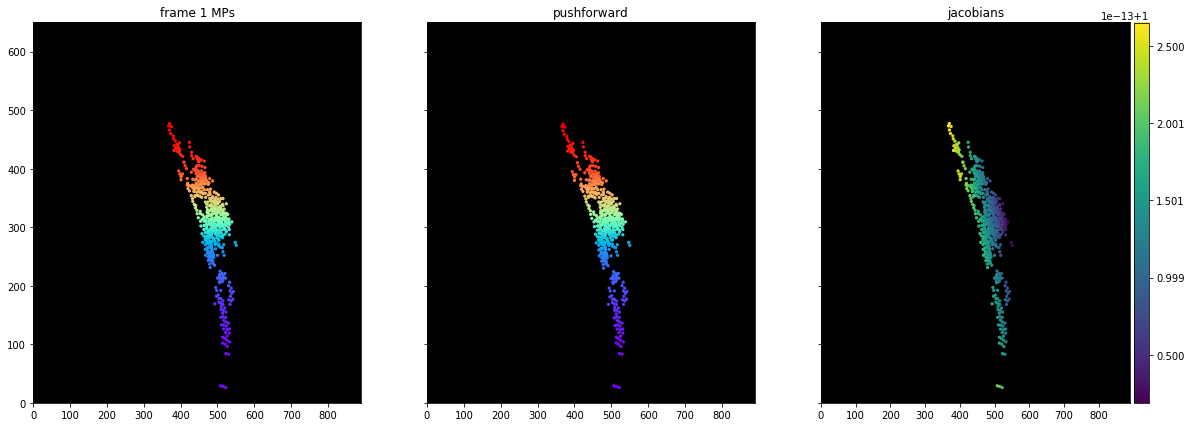

In [7]:
# Use lexical sorting to assign colors to points
mp_colors = get_mp_colors(mp_1.pts)

# Compute Jacobian determinants at MP points
jac_dets = model.det_jac(mp_1.pts).flatten()

# Plot MPs from frame 1 and their pushforwards
subplot_kw = {
    'facecolor': 'black',
    'xlim': [0, img_shape[0]],
    'ylim': [0, img_shape[1]],
}
fig, (ax_1, ax_2, ax_3) = plt.subplots(
    1, 3, sharex=True, sharey=True, subplot_kw=subplot_kw, figsize=(20, 7))

ax_1.set_title('frame 1 MPs')
ax_1.scatter(mp_1.pts[:, 0], mp_1.pts[:, 1], s=5, c=mp_colors)

ax_2.set_title('pushforward')
ax_2.scatter(pf_pts[:, 0], pf_pts[:, 1], s=5, c=mp_colors)
    
ax_3.set_title('jacobians')
im_3 = ax_3.scatter(mp_1.pts[:, 0], mp_1.pts[:, 1], s=5, c=jac_dets)
div_3 = make_axes_locatable(ax_3)
cax_3 = div_3.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im_3, cax=cax_3, orientation='vertical');